In [1]:
!git clone https://github.com/amitk0693/Prototype_Selection.git
import os
os.chdir("Prototype_Selection")

fatal: destination path 'Prototype_Selection' already exists and is not an empty directory.


In [2]:
# !pip install cvxpy
# !pip install gurobipy
# !pip install cvxpy[CBC,CVXOPT,GLOP,GLPK,GUROBI,MOSEK,PDLP,SCIP,XPRESS]

In [3]:
import numpy as np
from itertools import combinations
import re
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.metrics.pairwise import pairwise_distances
import umap

In [4]:
class Frontera:
    
    def __init__(self, X, y, percentil_min, percentil_max,N_points_frontera):
        self.X = X
        self.y = y
        self.percentil_min = percentil_min
        self.percentil_max = percentil_max
        self.N_points_frontera = N_points_frontera
        self.dic_categorias = {}
        self.dic_min_dst = {}
        self.list_dist_median = []
        
        self.dic_categorias_UMAP = {}
        self.dic_min_dst_UMAP = {}
        
        self.Frontier_Point_A_X = {}
        self.Frontier_Point_X_A = {}
        
        self.Frontier_Point = {}
        self.Frontier_Vector = {}
        self.class_vector = {}
        
    def distance(self,x0,x1):
        
        # X=(200,3) ; Y=(150,3)
        # diag(X*X')              <> (200,3) * (3,200) > diag(200,200) > (200,1)            X^2   (X-Y)^2
        # 2*X*Y'                  <>(200,3) * (3,150) > (200,150)                          -2XY
        # ones(N,1)*(diag(Y*Y'))' <> (200,1) * (150,1)' > (200,1) * (1,150) >(200,150)      Y^2
        # M_distance = diag(X*X')-2*X*Y'+ones(N,1)*(diag(Y*Y'))'  %%MATLAB
        M_distance = np.reshape( 
            np.diag(np.dot(x0,x0.T)),(-1,1)) - 2*np.dot(x0,x1.T) + np.dot( np.ones((x0.shape[0],1)), np.reshape(np.diag( np.dot(x1,x1.T)).T,(1,-1)) )
        return M_distance
       
    def get_frontier(self):

        for i in np.unique(self.y): 
            dic_categorias_aux ={'X_'+str(i):self.X[self.y==i]}
            self.dic_categorias.update(dic_categorias_aux)

        categorias_list =  [key for key in self.dic_categorias]
        comb_categories = combinations(categorias_list, 2)
        
        for categories in list(comb_categories):
            
            dist = self.distance(self.dic_categorias.get(categories[0]), self.dic_categorias.get(categories[1]))
            self.list_dist_median.append(np.median(dist))

            # row
            row = np.mean(dist, axis=1)
            select_indices_row = np.where( 
                (row > np.percentile(row, self.percentil_min)) & (row < np.percentile(row, self.percentil_max)) )[0]
            min_dst_row = self.dic_categorias.get(categories[0])[select_indices_row]
            dic_min_dst_aux ={categories[0]+'_with_'+categories[1]:min_dst_row} 
            self.dic_min_dst.update(dic_min_dst_aux)

            #Column
            column = np.mean(dist, axis=0)
            select_indices_column = np.where( 
                (column > np.percentile(column, self.percentil_min)) & (column < np.percentile(column, self.percentil_max)) )[0]
            min_dst_column = self.dic_categorias.get(categories[1])[select_indices_column]
            dic_min_dst_aux ={categories[1]+'_with_'+categories[0]:min_dst_column} 
            self.dic_min_dst.update(dic_min_dst_aux)

            
        list_all_frontier = [key for key in self.dic_min_dst]   
        for i in np.unique(self.y):
            
            my_regex = r"^X_" + str(i)
            p = re.compile(my_regex)
            list_A_with_X = [ s for s in list_all_frontier if p.match(s) ]
            
            my_regex = '.._with_X_' + str(i)
            my_regex = r".*" + str(i) + r'$'
            p = re.compile(my_regex)
            list_X_with_A = [ s for s in list_all_frontier if p.match(s) ]
            
            mtz_A = self.dic_min_dst.get(list_A_with_X[0])
            mtz_X = self.dic_min_dst.get(list_X_with_A[0])
            
            for j in range(1,len(list_A_with_X)):
                
                mtz_A = np.concatenate((mtz_A,self.dic_min_dst.get(list_A_with_X[j])), axis=0)
                mtz_X = np.concatenate((mtz_X,self.dic_min_dst.get(list_X_with_A[j])), axis=0)
                
                
            Front_Point_A_X ={'FrontPoints:(' + str(i) + ',X)' : mtz_A}    
            self.Frontier_Point_A_X.update(Front_Point_A_X)
            Front_Point_X_A ={'FrontPoints:(X,' + str(i) + ')' : mtz_X}    
            self.Frontier_Point_X_A.update(Front_Point_X_A)
            
        ## CALCULAR LOS CENTROIDES EN REGION DE FRONTERA
        for (key_A,value_A), (key_X,value_X) in zip(self.Frontier_Point_A_X.items(), self.Frontier_Point_X_A.items()):
    
            Point_A_X_copy = self.Frontier_Point_A_X.copy()
            Point_X_A_copy = self.Frontier_Point_X_A.copy()
            Front_Point = {}
            points_matriz = np.zeros(shape=(self.N_points_frontera, self.X.shape[1]))
            
            for i in range(0,self.N_points_frontera):
                
                dist = self.distance(Point_A_X_copy.get(key_A), Point_X_A_copy.get(key_X))

                #ROW
                min_dist_A_with_X = np.where( dist==np.min(dist) )[0]
                min_A_with_X = Point_A_X_copy.get(key_A)[min_dist_A_with_X]
                Point_A_X_copy.update({ key_A: np.delete(Point_A_X_copy.get(key_A), min_dist_A_with_X, axis=0)})

                #COLUMN
                min_dist_X_with_A = np.where( dist==np.min(dist) )[1]
                min_X_with_A = Point_X_A_copy.get(key_X)[min_dist_X_with_A]

                Point_X_A_copy.update({ key_X: np.delete(Point_X_A_copy.get(key_X), min_dist_X_with_A, axis=0)})
                
                point_value = (np.mean(min_A_with_X+min_X_with_A,axis=0))/2
                
                if i != 0:
                    closeness_criterion = self.distance(np.reshape(point_value,(-1,self.X.shape[1])), points_matriz) < 0.8          #################
                    
                    if not np.any(closeness_criterion == True):
                        points_matriz[i] = point_value
                        
                else:
                    points_matriz[i] = point_value
                
                if (Point_A_X_copy.get(key_A).shape[0] == 0) or (Point_X_A_copy.get(key_X).shape[0] == 0):
                    break
            
            row_points_matriz = np.sum(points_matriz, axis=1)
            select_indices_points_matriz = np.where( row_points_matriz != 0 )[0]
            points_matriz = points_matriz[select_indices_points_matriz]
            
            Front_Point ={'Frontier:' + key_A.split(':')[1] : points_matriz}    
            self.Frontier_Point.update(Front_Point)
        
        
        ### CALCULAR LOS VECTORES
        for (key_region,region), (key_Frontier,Frontier_Point) in zip(self.dic_categorias.items(), self.Frontier_Point.items()):
        #for A_with_B, Frontier_Point in zip(list_A_with_B,list_Frontier_Point):
                        
            Front_vector = {}
            n_row = 0
            vectors_matriz = np.zeros(shape=(self.Frontier_Point.get(key_Frontier).shape[0], self.X.shape[1]))
            
            #print(A_with_B,'--',Frontier_Point)
            
            for key_Frontier in self.Frontier_Point.get(key_Frontier):

                dist = self.distance(self.dic_categorias.get(key_region), np.reshape(key_Frontier,(-1,self.X.shape[1])) ) 

                #ROW
                min_dist_A_with_B = np.where( dist <= 2)[0]                                                                        #################
                min_A_with_B = self.dic_categorias.get(key_region)[min_dist_A_with_B]        

                vector_value = np.median(min_A_with_B,axis=0)
                #print(dic_min_dst_copy.get(A_with_B))
                vectors_matriz[n_row] = vector_value
               
                n_row += 1
            
            Front_vector ={'Vec_Frontier:(X,' + key_region.split('_')[-1] + ')' : vectors_matriz}    
            self.Frontier_Vector.update(Front_vector) 
            
        for (key_origin,value_origin), (key_vec,value_vector) in zip(self.Frontier_Point.items(), self.Frontier_Vector.items()):
            
            vector_aux = np.concatenate((value_origin,value_vector-value_origin), axis=1)
            class_vec = {'Class_vector:' + key_vec.split(':')[1] : vector_aux}
            self.class_vector.update(class_vec) 
            
        ########################
        ### FILTRAR VECTORES ###
        ########################
        ## Unir todos los Frontier_Point en 1 matriz
        mtz_origin = self.Frontier_Point.get([key for key in self.Frontier_Point][0])
        for j in range( 1, len([key for key in self.Frontier_Point]) ):
            mtz_origin = np.concatenate((mtz_origin,self.Frontier_Point.get([key for key in self.Frontier_Point][j])), axis=0)

        ## Calcular matriz de distancias entre todos los Frontier_Point e imputar diagonal de dist Max
        dist_mtz_origin = self.distance(mtz_origin, mtz_origin)
        dis_max = np.max(dist_mtz_origin)
        indent_max = np.nan_to_num(np.identity(dist_mtz_origin.shape[0])*dis_max)        
        dist_mtz_origin = (dist_mtz_origin + indent_max)
        
        mtz_bool_eucl = dist_mtz_origin < 2
        
        ## Unir todos los vectores en 1 matriz
        
        mtz_vec = self.class_vector.get([key for key in self.class_vector][0])
        for j in range( 1, len([key for key in self.class_vector]) ):
            mtz_vec = np.concatenate((mtz_vec,self.class_vector.get([key for key in self.class_vector][j])), axis=0)
        mtz_vec = mtz_vec[:,self.X.shape[1]:]
        
        # first filter
        dist_cosine = 1-pairwise_distances(mtz_vec, metric="cosine") 
        mtz_bool_cos = dist_cosine <= -0.9
        
        diag = np.triu(np.ones(dist_mtz_origin.shape), 1).T == 1
        
        regla = mtz_bool_cos & mtz_bool_eucl & diag 
        select_indices_1 = np.where( regla==True )[0]
        select_indices_2 = np.where( regla==True )[1]
                
        origin_redu = mtz_origin[select_indices_1] 
        vec_redu = mtz_vec[select_indices_1] 
        
        Front_Point = {'Frontier: Reduct': origin_redu}
        self.Frontier_Point.update(Front_Point)
        
        Front_vector ={'Vec_Frontier: Reduct' : vec_redu+origin_redu}    
        self.Frontier_Vector.update(Front_vector) 

        class_vec = {'Class_vector_Reduct:': np.concatenate((origin_redu,vec_redu), axis=1)}
        self.class_vector.update(class_vec)
        
        ## seconf filter
        dist_cosine_2 = 1-pairwise_distances(vec_redu, metric="cosine") 
        mtz_bool_cos_2 = dist_cosine_2 <= 0.8
        diag_2 = np.triu(np.ones(dist_cosine_2.shape), 1).T == 1
        regla_2 = mtz_bool_cos_2 & diag_2
        print(regla_2)
        
        select_indices_1_1 = np.where( regla_2==True )[0]
        
        origin_redu_2 = origin_redu[select_indices_1_1] 
        vec_redu_2 = vec_redu[select_indices_1_1]

        
        Front_Point = {'Frontier: Full Reduct': origin_redu_2}
        self.Frontier_Point.update(Front_Point)
        
        Front_vector ={'Vec_Frontier: Full Reduct' : vec_redu_2+origin_redu_2}    
        self.Frontier_Vector.update(Front_vector) 

        class_vec = {'Class_vector_Full_Reduct:': np.concatenate((origin_redu_2,vec_redu_2), axis=1)}
        self.class_vector.update(class_vec)
        
        #print('------------')
        #print(select_1)
        #print('------------')
        print()
        print()


        
        self.color_list = [0] * len(self.dic_categorias.keys())
        for i in range( len(self.dic_categorias.keys()) ):
            self.color_list[i] = np.random.randint(0, 1000)
        
            
    def plot_muestra_2D(self, col_1, col_2,include_layout=True):
        
        
        door = True
        next_color = 0
        
        
        for key, value in self.dic_categorias.items(): 

            if door:
                fig = go.Figure(data=[go.Scatter(x=value[:, col_1], y=value[:, col_2],
                                                 mode='markers', 
                                                 name= key,
                                                 marker=dict(
                                                     size=6,
                                                     #color=self.color_list[next_color],                # set color to an array/list of desired values
                                                     colorscale='picnic',   # choose a colorscale
                                                     opacity=0.7)
                                                )])
                door = False
                next_color += 1
                
            else:
                
                fig.add_trace(go.Scatter(x=value[:,col_1], y=value[:,col_2],
                                     mode='markers', 
                                     name= key,
                                     marker=dict(
                                         size=6,
                                         #color=self.color_list[next_color],                # set color to an array/list of desired values
                                         colorscale='picnic',   # choose a colorscale
                                         opacity=0.7)
                                    ))
                next_color += 1
              
        if include_layout:
            
            fig.update_layout(
                autosize=False,
                width=600,
                height=600,
                margin=dict(l=0, r=0, b=0, t=10))

            fig.show()
            

    def plot_frontera_2D(self, col_1, col_2):    
        
       
        #self.plot_muestra_2D(col_1, col_2, include_layout=False)
        
        door = True
        next_color = 0
        
        
        for key, value in self.dic_categorias.items(): 

            if door:
                fig = go.Figure(data=[go.Scatter(x=value[:, col_1], y=value[:, col_2],
                                                 mode='markers', 
                                                 name= key,
                                                 marker=dict(
                                                     size=6,
                                                     #color=self.color_list[next_color],                # set color to an array/list of desired values
                                                     colorscale='picnic',   # choose a colorscale
                                                     opacity=0.7)
                                                )])
                door = False
                next_color += 1
                
            else:
                
                fig.add_trace(go.Scatter(x=value[:,col_1], y=value[:,col_2],
                                     mode='markers', 
                                     name= key,
                                     marker=dict(
                                         size=6,
                                         #color=self.color_list[next_color],                # set color to an array/list of desired values
                                         colorscale='picnic',   # choose a colorscale
                                         opacity=0.7)
                                    ))
                next_color += 1
        
        for key, value_dst in self.Frontier_Point_A_X.items(): 

            fig.add_trace(go.Scatter(x=value_dst[:,col_1], y=value_dst[:,col_2],
                                     mode='markers', 
                                     name= key,
                                     marker=dict(
                                         symbol=220,
                                         size=14,
                                         color=np.random.randint(100),                # set color to an array/list of desired values
                                         #colorscale='Viridis',   # choose a colorscale
                                         opacity=1)
                                    ))
            
        for key, value_dst in self.Frontier_Point_X_A.items(): 

            fig.add_trace(go.Scatter(x=value_dst[:,col_1], y=value_dst[:,col_2],
                                     mode='markers', 
                                     name= key,
                                     marker=dict(
                                         symbol=220,
                                         size=14,
                                         color=np.random.randint(100),                # set color to an array/list of desired values
                                         #colorscale='Viridis',   # choose a colorscale
                                         opacity=1)
                                    ))
            
        for key, value_dst in self.Frontier_Point.items(): 

            fig.add_trace(go.Scatter(x=value_dst[:,col_1], y=value_dst[:,col_2],
                                     mode='markers', 
                                     name= key,
                                     marker=dict(
                                         symbol=300,
                                         size=50,
                                         color=np.random.randint(100),                # set color to an array/list of desired values
                                         #colorscale='Viridis',   # choose a colorscale
                                         opacity=1)
                                    ))

        fig.update_layout(
            autosize=True,
            width=1200,
            height=750,
            margin=dict(l=10, r=10, b=10, t=20))

        fig.show()
        

    def plot_Vectors(self, col_1, col_2):    
        
        door = True
        next_color = 0
        
        for key, value in self.dic_categorias.items(): 

            if door:
                fig = go.Figure(data=[go.Scatter(x=value[:, col_1], y=value[:, col_2],
                                                 mode='markers', 
                                                 name= key,
                                                 marker=dict(
                                                     size=6,
                                                     #color=self.color_list[next_color],                # set color to an array/list of desired values
                                                     colorscale='picnic',   # choose a colorscale
                                                     opacity=0.7)
                                                )])
                door = False
                next_color += 1
                
            else:
                
                fig.add_trace(go.Scatter(x=value[:,col_1], y=value[:,col_2],
                                     mode='markers', 
                                     name= key,
                                     marker=dict(
                                         size=6,
                                         #color=self.color_list[next_color],                # set color to an array/list of desired values
                                         colorscale='picnic',   # choose a colorscale
                                         opacity=0.7)
                                    ))
                next_color += 1

        
            
        for key, value_dst in self.Frontier_Point.items(): 

            fig.add_trace(go.Scatter(x=value_dst[:,col_1], y=value_dst[:,col_2],
                                     mode='markers', 
                                     name= key,
                                     marker=dict(
                                         symbol=300,
                                         size=50,
                                         color=np.random.randint(100),                # set color to an array/list of desired values
                                         #colorscale='Viridis',   # choose a colorscale
                                         opacity=1)
                                    ))
            
        for key, value_dst in self.Frontier_Vector.items(): 

            fig.add_trace(go.Scatter(x=value_dst[:,col_1], y=value_dst[:,col_2],
                                     mode='markers', 
                                     name= key,
                                     marker=dict(
                                         symbol=2,
                                         size=15,
                                         color=np.random.randint(100),                # set color to an array/list of desired values
                                         #colorscale='Viridis',   # choose a colorscale
                                         opacity=1)
                                    ))
            
        for key, value in self.class_vector.items():
            
            col_1_ = int(col_1+value.shape[1]/2)
            col_2_ = int(col_2+value.shape[1]/2)
            
            locals()['fig_{}'.format(key)] = ff.create_quiver(x=value[:,col_1],  y=value[:,col_2],
                                   u=value[:,col_1_], v=value[:,col_2_],
                           scale=1,
                           arrow_scale=.3,
                           name=key,
                           line_width=1.5)
            
            fig.add_traces(data = locals()['fig_{}'.format(key)].data)

            
        
        fig.update_layout(
            autosize=True,
            width=1200,
            height=750,
            margin=dict(l=10, r=10, b=10, t=20))

        fig.show()        
        
        
        
    def plot_UMAP(self):    
        
        trans = umap.UMAP(random_state=42).fit(self.X)

        for key, value in self.dic_categorias.items():
            value_UMAP = trans.transform(value)
            dic_categorias_aux ={key:value_UMAP}
            self.dic_categorias_UMAP.update(dic_categorias_aux)

        for key, value in self.dic_min_dst.items():
            value_UMAP = trans.transform(value)
            dic_min_dst_aux ={key:value_UMAP}
            self.dic_min_dst_UMAP.update(dic_min_dst_aux)
        
        door = True
        next_color = 0
        
        
        for key, value in self.dic_categorias_UMAP.items(): 

            if door:
                fig = go.Figure(data=[go.Scatter(x=value[:,0], y=value[:,1],
                                                 mode='markers', 
                                                 name= key,
                                                 marker=dict(
                                                     size=6,
                                                     #color=self.color_list[next_color],                # set color to an array/list of desired values
                                                     colorscale='picnic',   # choose a colorscale
                                                     opacity=0.7)
                                                )])
                door = False
                next_color += 1
                
            else:
                
                fig.add_trace(go.Scatter(x=value[:,0], y=value[:,1],
                                     mode='markers', 
                                     name= key,
                                     marker=dict(
                                         size=6,
                                         #color=self.color_list[next_color],                # set color to an array/list of desired values
                                         colorscale='picnic',   # choose a colorscale
                                         opacity=0.7)
                                    ))
                next_color += 1
        
        for key, value_dst in self.dic_min_dst_UMAP.items(): 

            fig.add_trace(go.Scatter(x=value_dst[:,0], y=value_dst[:,1],
                                     mode='markers', 
                                     name= key,
                                     marker=dict(
                                         symbol=220,
                                         size=14,
                                         color=np.random.randint(100),                # set color to an array/list of desired values
                                         #colorscale='Viridis',   # choose a colorscale
                                         opacity=1)
                                    ))

        fig.update_layout(
            autosize=True,
            width=800,
            height=600,
            margin=dict(l=10, r=10, b=10, t=20))

        fig.show()

In [5]:
import cvxpy as cvx
import numpy as np
from scipy.stats import bernoulli
from cvxpy import GUROBI as solverGUROBI

class prototype_classifier:

    """ A ball is drawn around every element in the distance matrix with radius
        epsilon. The element whose ball covers most other elements is selected
        as prototype. All such covered elements and the new prototype are
        removed for the next round. This is repeated until no balls cover more
        than its center element.
    	
        Parameters
        ----------
        _epsilon: float
            A hyperparameter, indicating the region covered by the prototypes with radius epsilon.

        Attributes
        ----------
        self.X: M x N matrix
            Training data set.
        self.y: M x 1 vector
            Class label of the training data set self.X.
        self.lengthX: int
            Training data length.
        self._epsilon: float
            Ball radius.
        self._lambda: float
            a scalar for normalisation.
    """

    def __init__(self, _epsilon):

            self._lambda = None
            self.c_w_ = None
            self.w_ = None
            self.X = None
            self.y = None
            self.lengthX = None
            self._epsilon = _epsilon
            self.lengthL = None
            self.label = None
            self.data_info = None
            # Variables for solving relaxed Integer Program.
            self.xi_n_lin = None
            self.alpha_j_lin = None
            self.opt_val = None
            # Variables for solving the Randomized Rounding Algorithm.
            self.prototype_length = None
            self.random_round_Sn = None
            self.random_round_Aj = None
            self.random_round_optimal_val = None

    def labelsInfo(self):
        """ Extracts the unique class label from the data X.

            Attributes
            ----------
            self.label : set 
                Stores unique class labels.

            Returns
            -------
            set of class labels.
        """
        self.label = set(self.y)
        return self.label

    def getNumLabel(self):
        """ Extracts the length of the class labels.

            Attributes
            ----------
            self.lengthL : int
                length of the class labels.
            
            Returns
            -------
            self.length : int
                length of the class labels.
           
        """
        self.lengthL = len(self.label)
        return self.lengthL 

    def dataInfo(self, label):
        """Creates a data dictionary according to the class label passed as argument label.

            Parameter
            ---------
            label: int
                contains the label number.

            Attributes
            ----------
            indexes: list[int]
                indices, where label is equal to the class label of the data.
            X_l: data
                subset of the training data with indexes as index.
            y_l: data
                class label of the data X_l.
            size_l: int
                length of the data with the same label.
            indexes_not_l: list[int]
                indices, where label is not equal to the class label of the data.
            X_not_l: data
                subset of data where the label is not equal to the class label.
            y_not_l: data
                contains the label which is not equal to the label.
            size_not_l: list[int]
                length of the data which is not of the same label.
            data: dict
                contains the data where argument label is equal to the class label.
            
            Returns
            -------
            data: data dictionary containing data with class label equal to label and class label not
                equal to label.
        """
        indexes = [idx for idx, lbl in enumerate(self.y) if lbl == label]
        X_l = self.X[indexes]
        y_l = self.y[indexes]
        size_l = X_l.shape[0]
        indexes_not_l = [idx for idx, lbl in enumerate(self.y) if lbl != label]
        X_not_l = self.X[indexes_not_l]
        y_not_l = self.y[indexes_not_l]
        size_not_l = X_not_l.shape[0]
        data = {
            "X_l": X_l,
            "y_l": y_l,
            "indices_l": indexes,
            "size_l": size_l,
            "X_not_l": X_not_l,
            "y_not_l": y_not_l,
            "indices_not_l": indexes_not_l,
            "size_not_l": size_not_l,
        }
        return data

    def checkNeighborhood(self, x, x_test):
        """ Checks if a point is in the epsilon ball or if a point 'x_test' is in the epsilon neighborhood of a
            point 'x'.
        
            Parameter
            ---------
            x: vector
                center of the epsilon ball.
            x_test: vector
                point to be checked if it lies in the ball with radius epsilon or not.
            
            Attribute
            ---------
                result: bool
                    Checks if the point is in neighbourhood or not.
            
            Returns
            -------
                True, if a point lies in the neighborhood of epsilon ball centered around parameter
                x otherwise, returns False.
        """
        result = np.linalg.norm((x - x_test), ord=2, keepdims=True) <= self._epsilon
        return result

    def calculate_Clj(self, label):
        """ Calculates the total number of data samples(with different label) if it comes in the epsilon 
            neighborhood of a point if a point is chosen as a prototype.

            Parameter 
            ---------
            label: int
                contains a class label.
            
            Attributes
            ----------
            data: dict
                contains the data dictionary according to the argument label.
            X_l: Any
                contains the data with same class label.
            X_not_l: Any
                contains the data where label is not equal to class label.
            sets_C_lj: list[int]
                contains number of points covered where, class label is not equal to true label if x_jl is
                considered as prototype.
            
            Returns
            -------
            Cost of adding a point.
        """
        data = self.dataInfo(label=label)
        X_l = data["X_l"]
        X_not_l = data["X_not_l"]
        sets_C_lj = []
        for x_jl in X_l:
            temp = 0
            for x_no_l in X_not_l:
                if self.checkNeighborhood(x_jl, x_no_l):
                    temp += 1
            sets_C_lj.append(temp)
        C_lj = [(self._lambda + set_C_lj) for set_C_lj in sets_C_lj]
        data["C_lj"] = np.array(C_lj)
        return data

    def checkCoverPoints(self, label):
        """ Checks for neighborhood points, if a point is in the ball with radius epsilon(for the
            chosen data as a prototype) then, the value for that index is 1 else it is zero.

            Parameter
            ---------
            label: int
                Contains a class label.

            Attributes
            ----------
            X_l: data
                subset of the training data with indexes as index.
            size_l: int
                length of the data with the same label.
            constraint_matrix: int
                size_l X size_l matrix which contains the neighborhood information.

            Returns
            -------
            data:  updates the data dictionary with pairwise neighborhood information.
        """
        data = self.calculate_Clj(label=label)
        X_l = data["X_l"]
        size_l = data["size_l"]
        constraint_matrix = np.zeros(shape=(size_l, size_l))
        for x_nl in range(size_l):
            for x_jl in range(size_l):
                if self.checkNeighborhood(X_l[x_jl], X_l[x_nl]):
                    constraint_matrix[x_nl][x_jl] = 1
        data["constraint_matrix"] = constraint_matrix
        return data

    def fit(self, train_X, train_y,):
        """ Here the model is trained according to the class label using convex optimisation method.
            Attributes are added to the data dictionary for Randomized rounding algorithm for optimal
            parameters. 

            Attributes
            ----------
            train_X: M x N matrix
                Training data set.
            train_y: M x 1 vector
                Class label of the training data set.
            label: int
                contains set of unique labels.
            alpha_j_lin: vector
                stores the alpha value after optimisation.
            xi_n_lin: vector
                stores Xi value after optimisation.
            opt_val_lin: list
                contains the optimal value of the Objective function.
            update_data_info:
                updates the data dictionary with the attributes above.
        """
        self.X = train_X
        self.y = train_y
        self.lengthX = len(self.X)
        self._lambda = 1/ self.lengthX
        label = self.labelsInfo()
        alpha_j_lin = np.zeros(shape=self.lengthX)
        xi_n_lin = np.zeros(shape=self.lengthX)
        opt_val_lin = []
        update_data_info = []

        for lbl in label:
            data = self.checkCoverPoints(label=lbl)
            size_l = data["size_l"]
            C_lj = data["C_lj"]
            alpha_jl = cvx.Variable(shape=size_l)
            xi_nl = cvx.Variable(shape=size_l)
            constraint_matrix = data["constraint_matrix"]
            zero_vec = np.zeros(shape=size_l)
            one_vec = np.ones(shape=size_l)
            # Objective function for minimisation.
            objective = cvx.Minimize((C_lj @ alpha_jl) + sum(xi_nl))
            # Constraints for the minimisation.
            constraints = [(constraint_matrix @ alpha_jl >= (one_vec - xi_nl)),
                           alpha_jl >= zero_vec,
                           alpha_jl <= one_vec,
                           xi_nl >= zero_vec]

            prob = cvx.Problem(objective, constraints)
            prob.solve(solver=solverGUROBI)

            data["alpha_jl_lp"] = [1 if alpha_jl >= 1 else alpha_jl for alpha_jl in alpha_jl.value]
            data["alpha_jl_lp"] = [0 if alpha_jl <= 0 else alpha_jl for alpha_jl in data["alpha_jl_lp"]]
            data["xi_nl_lp"] = [1 if xi_nl >= 1 else xi_nl for xi_nl in xi_nl.value]
            data["xi_nl_lp"] = [0 if xi_nl <= 0 else xi_nl for xi_nl in data["xi_nl_lp"]]

            first_term = sum([(c_lj * alpha_jl) for c_lj, alpha_jl in zip(data["C_lj"], data["alpha_jl_lp"])])
            second_term = sum(data["xi_nl_lp"])
            # calculate the optimal value after the optimisation.
            optimal_l = first_term + second_term

            data["optimal_l_lp"] = optimal_l
            opt_val_lin.append(optimal_l)
            update_data_info.append(data)

            indices_l = data["indices_l"]
            for idx in indices_l:
                alpha_j_lin[idx] = alpha_jl.value[indices_l.index(idx)]
                xi_n_lin[idx] = xi_nl.value[indices_l.index(idx)]

        self.alpha_j_lin = alpha_j_lin
        self.xi_n_lin = xi_n_lin
        self.opt_val = sum(opt_val_lin)
        self.data_info = update_data_info
        self.objectiveValue()

    def objectiveValue(self):
        """ Here Randomized Rounding Algorithm is performed to recover the integer values we need 
            for our indicator variable, we choose to round our optimal variables of the linear program.

            Attributes
            ----------
            data_info:

            label:
                 contains set of unique labels.
            random_round_Aj:

            random_round_Sn:
            random_round_optimal_value:
            update_data_info:
        """
        data_info = self.data_info
        label = self.labelsInfo()
        random_round_Aj = np.zeros(shape=self.lengthX)
        random_round_Sn = np.zeros(shape=self.lengthX)
        random_round_optimal_value = []
        update_data_info = []
        for lbl in label:
            data = data_info[lbl]
            size_l = data["size_l"]
            temp_random_round_Ajl = np.zeros(shape=size_l, dtype=int)
            temp_random_round_Snl = np.zeros(shape=size_l, dtype=int)
            temp_optimal_round = float('nan')
            C_lj = data["C_lj"]
            alpha_jl_lp = data["alpha_jl_lp"]
            xi_nl_lp = data["xi_nl_lp"]
            optimal_l_lp = data["optimal_l_lp"]
            optimal_l_log = 2 * np.log (size_l) * optimal_l_lp
            repeat = True
            while repeat:
                temp_random_round_Ajl = np.zeros(shape=size_l, dtype=int)
                temp_random_round_Snl = np.zeros(shape=size_l, dtype=int)

                for l in range(int(np.ceil(2 * np.log(size_l)))):
                    for j in range(size_l):
                        temp_round_Ajl = bernoulli.rvs(alpha_jl_lp[j])
                        temp_random_round_Ajl[j] = max(temp_round_Ajl, temp_random_round_Ajl[j])
                        temp_round_Snl = bernoulli.rvs(xi_nl_lp[j])
                        temp_random_round_Snl[j] = max(temp_round_Snl, temp_random_round_Snl[j])

                constraint_matrix = data["constraint_matrix"]
                first_term = sum([c_lj * A_jl for c_lj, A_jl in zip(C_lj, temp_random_round_Ajl)])
                second_term = sum(temp_random_round_Snl)
                temp_optimal_round = first_term + second_term

                get_val_Ajl = constraint_matrix @ temp_random_round_Ajl
                get_val_Sn = 1 - temp_random_round_Snl
                if all ([lhs >= rhs for lhs, rhs in zip(get_val_Ajl, get_val_Sn)]):
                    if all ([(A_jl == 0 or A_jl == 1) for A_jl in temp_random_round_Ajl]):
                        if all ([S_nl >= 0 for S_nl in temp_random_round_Snl]):
                            if temp_optimal_round <= optimal_l_log:
                                repeat = False

            data["random_round_Ajl"] = temp_random_round_Ajl
            data["random_round_Snl"] = temp_random_round_Snl
            data["optimal_val_random"] = temp_optimal_round
            random_round_optimal_value.append(temp_optimal_round)
            update_data_info.append(data)

            indices_l = data["indices_l"]
            for idx in indices_l:
                random_round_Aj[idx] = temp_random_round_Ajl[indices_l.index(idx)]
                random_round_Sn[idx] = temp_random_round_Snl[indices_l.index(idx)]

        self.random_round_Aj = random_round_Aj
        self.random_round_Sn = random_round_Sn
        self.random_round_optimal_val = sum(random_round_optimal_value)

        self.w_ = [x for x, A_j in zip(self.X, self.random_round_Aj) if A_j == 1]
        self.w_ = np.array (self.w_)

        self.c_w_ = [y for y, A_j in zip(self.y, self.random_round_Aj) if A_j == 1]
        self.prototype_length = self.w_.shape[0]
        self.data_info = update_data_info

    def predict(self, x_predict):
        """ Test Error: After choosing prototypes, classify a point as the label of the nearest 
            prototype.
            Cover Error: After choosing prototypes, classify a point to the class label of the nearest
            prototype if it lies in epsilon range of the prototype, If no such prototypes
            exist then count it as mis-classification.

            Parameter
            ---------
            x_predict:
                unseen data to test the model.
            
            Attributes
            ----------
            prototypes: list | ndarray
                contains chosen prototypes.
            prototype_label: list
                contains the label of the prototypes.
            y_test_predict:  list
                test error for mis-classification.
            y_cover_predict: list
                cover error for mis-classification.
            
            Returns
            -------
            y_test_predict: list
            y_cover_predict: list
        """


        prototypes = self.w_
        prototype_label = self.c_w_

        y_test_predict = []
        y_cover_predict = []

        for i in x_predict:
            distances = []
            neighborhood = []
            for x in prototypes:
                dist = np.linalg.norm((x - i), ord=2, keepdims=True)
                distances.append(dist)
                neighborhood.append(dist <= self._epsilon)

            idx = np.argmin(distances)
            y_test_predict.append(prototype_label[idx])

            if sum(neighborhood) == 1.0:
                idx = neighborhood.index(1)
                y_cover_predict.append(prototype_label[idx])

            if sum(neighborhood) > 1.0:
                labels = [label for label, y_index in zip(prototype_label, neighborhood) if y_index == 1]
                if labels.count(labels[0]) == len(labels):
                    y_cover_predict.append(labels[0])
                else:
                    y_cover_predict.append(-2)

            if sum(neighborhood) < 1.0:
                y_cover_predict.append(-50)

        return y_test_predict

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate the dataset
X, y = make_blobs(
    n_samples=600,
    n_features=2,
    centers=3,
    cluster_std=1,
    shuffle=True,
    random_state=0
)

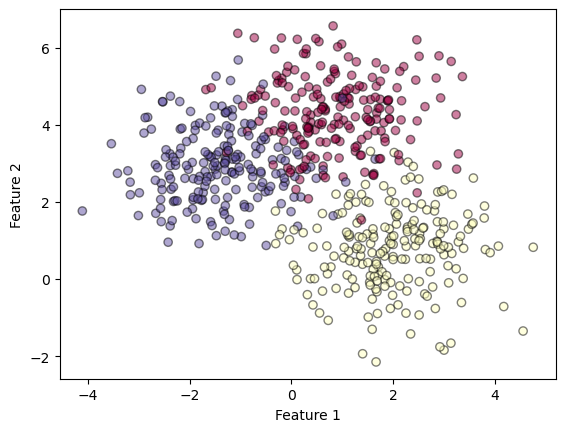

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=plt.cm.Spectral, alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [8]:
frontera = Frontera(X,y,percentil_min=5, percentil_max=20, N_points_frontera=41)
frontera.get_frontier()

[[False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [ True  True  True False False False]
 [ True  True  True False False False]
 [ True  True  True  True  True False]]




In [9]:
frontera.Frontier_Point_A_X

{'FrontPoints:(0,X)': array([[ 0.62227617,  2.92883603],
        [ 0.37761614,  3.18789034],
        [ 0.1631238 ,  2.57750473],
        [ 0.46546494,  3.12315514],
        [ 1.25671178,  3.31066372],
        [ 3.2460247 ,  2.84942165],
        [ 0.93698726,  3.13569383],
        [ 0.28843247,  3.08970992],
        [ 0.21212615,  2.86599585],
        [ 0.16290582,  2.837363  ],
        [ 3.28018678,  3.2437715 ],
        [ 2.34080193,  3.61433814],
        [ 2.102906  ,  3.22385582],
        [ 0.2506727 ,  2.92042337],
        [ 0.62283833,  2.68731314],
        [ 1.28933778,  3.44969159],
        [ 1.35269561,  3.20438654],
        [ 0.70853654,  3.175776  ],
        [ 1.25078644,  3.41287224],
        [-0.00924066,  2.83195232],
        [ 1.37227679,  3.21072582],
        [ 1.83310069,  3.65276173],
        [ 2.85942078,  2.95602827],
        [-0.07228289,  2.88376939],
        [ 1.37861172,  3.61897724],
        [ 1.84070628,  3.56162231],
        [-0.02394527,  2.75901623],
       

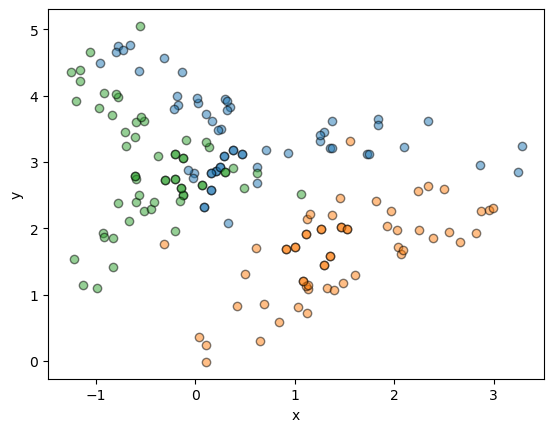

In [10]:
import matplotlib.pyplot as plt

front_points = frontera.Frontier_Point_A_X

for key in front_points:
    points = front_points[key]
    plt.scatter(points[:, 0], points[:, 1], edgecolors="k", cmap=plt.cm.Spectral, alpha=0.5)

plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [11]:
X_1 = []
y_1 = []
for key, value in frontera.Frontier_Point_A_X.items():
    for point in value:
        X_1.append(point)
        y_1.append(int(''.join(filter(str.isdigit, key.split(':')[1]))))
X_1 = np.array(X_1)
y_1 = np.array(y_1)


In [12]:
X_1

array([[ 0.62227617,  2.92883603],
       [ 0.37761614,  3.18789034],
       [ 0.1631238 ,  2.57750473],
       [ 0.46546494,  3.12315514],
       [ 1.25671178,  3.31066372],
       [ 3.2460247 ,  2.84942165],
       [ 0.93698726,  3.13569383],
       [ 0.28843247,  3.08970992],
       [ 0.21212615,  2.86599585],
       [ 0.16290582,  2.837363  ],
       [ 3.28018678,  3.2437715 ],
       [ 2.34080193,  3.61433814],
       [ 2.102906  ,  3.22385582],
       [ 0.2506727 ,  2.92042337],
       [ 0.62283833,  2.68731314],
       [ 1.28933778,  3.44969159],
       [ 1.35269561,  3.20438654],
       [ 0.70853654,  3.175776  ],
       [ 1.25078644,  3.41287224],
       [-0.00924066,  2.83195232],
       [ 1.37227679,  3.21072582],
       [ 1.83310069,  3.65276173],
       [ 2.85942078,  2.95602827],
       [-0.07228289,  2.88376939],
       [ 1.37861172,  3.61897724],
       [ 1.84070628,  3.56162231],
       [-0.02394527,  2.75901623],
       [ 1.72345841,  3.11484237],
       [ 1.74952306,

In [13]:
y_1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2])

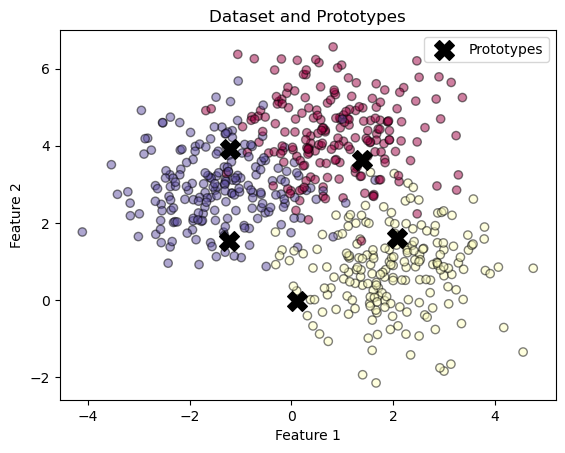

In [36]:
# Instantiate the PrototypeSelection class
proto_selector = prototype_classifier(_epsilon=1.5)

# Fit the prototype_classifier to the data
proto_selector.fit(X_1, y_1)

# Get the selected prototypes and their labels
prototypes = proto_selector.w_
prototype_labels = proto_selector.c_w_

# Plot the data points and prototypes
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=plt.cm.Spectral, alpha=0.5)
plt.scatter(prototypes[:, 0], prototypes[:, 1], c='black', marker='X', s=200, label='Prototypes')

# Customize the plot
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Dataset and Prototypes')

# Show the plot
plt.show()

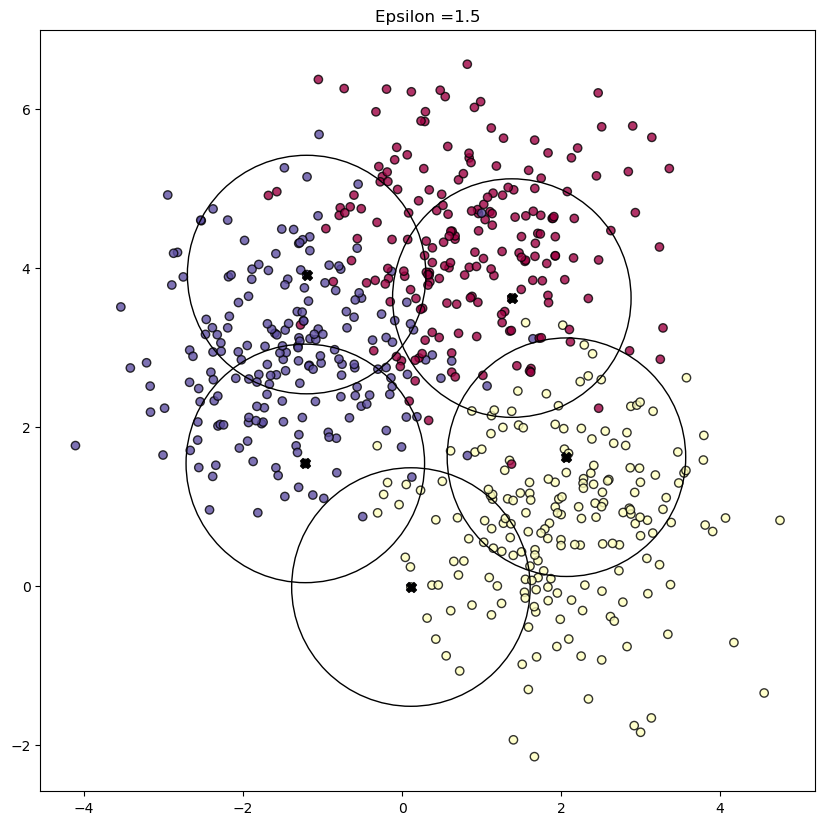

In [37]:
#figure, axes = plt.subplots()
fig = plt.figure(figsize=(10, 10))
axes = fig.add_subplot()
#axes.axis([-2.29,3.4,-1.82,2.25])
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(prototypes[:, 0], prototypes[:, 1], c='black', marker='X', s=50, edgecolors="k")
prototypes_l0, prototypes_l1 = [],[]
for i, j in zip(prototypes, prototype_labels):
    if j == 0:
        draw_circle = plt.Circle((i[0], i[1]), proto_selector._epsilon, fill=False, edgecolor='black', linewidth=1)
        axes.set_aspect(1)
        axes.add_artist(draw_circle)
    else:
        draw_circle1 = plt.Circle ((i[0], i[1]), proto_selector._epsilon, fill=False, edgecolor='black', linewidth=1)
        axes.set_aspect (1)
        axes.add_artist (draw_circle1)
#plt.tight_layout()
plt.title('Epsilon =' + str(proto_selector._epsilon))
plt.show()

In [17]:
from sklearn.model_selection import KFold

class prototype_classifier_cv(prototype_classifier):

    def __init__(self, _epsilon_list):
        self._epsilon_list = _epsilon_list
        super().__init__(None)

    def fit(self, X, y):
        best_epsilon = None
        best_accuracy = -1
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        for epsilon in self._epsilon_list:
            accuracy = 0
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                self._epsilon = epsilon
                super().fit(X_train, y_train)
                y_pred = self.predict(X_test)
                accuracy += np.mean(y_pred == y_test)
            accuracy /= 5
            if accuracy > best_accuracy:
                best_epsilon = epsilon
                best_accuracy = accuracy
        self._epsilon = best_epsilon
        super().fit(X, y)

In [ ]:
# mu = 1.5 # media
# sigma = 0.5 # desviación estándar
# num_epsilons = 10 # número de valores de epsilon a generar

# epsilons = np.random.normal(mu, sigma, num_epsilons)
# epsilons = np.clip(epsilons, 0, 3) # asegurarse de que todos los valores estén entre 0 y 3

In [30]:
epsilons = [0.1, 0.2, 0.3, 0.5, 1, 1.5, 2, 2.5, 3]
proto_selector_cv = prototype_classifier_cv(epsilons)

In [31]:
proto_selector_cv.fit(X_1, y_1)

In [32]:
prototypes = proto_selector_cv.w_
prototype_labels = proto_selector_cv.c_w_

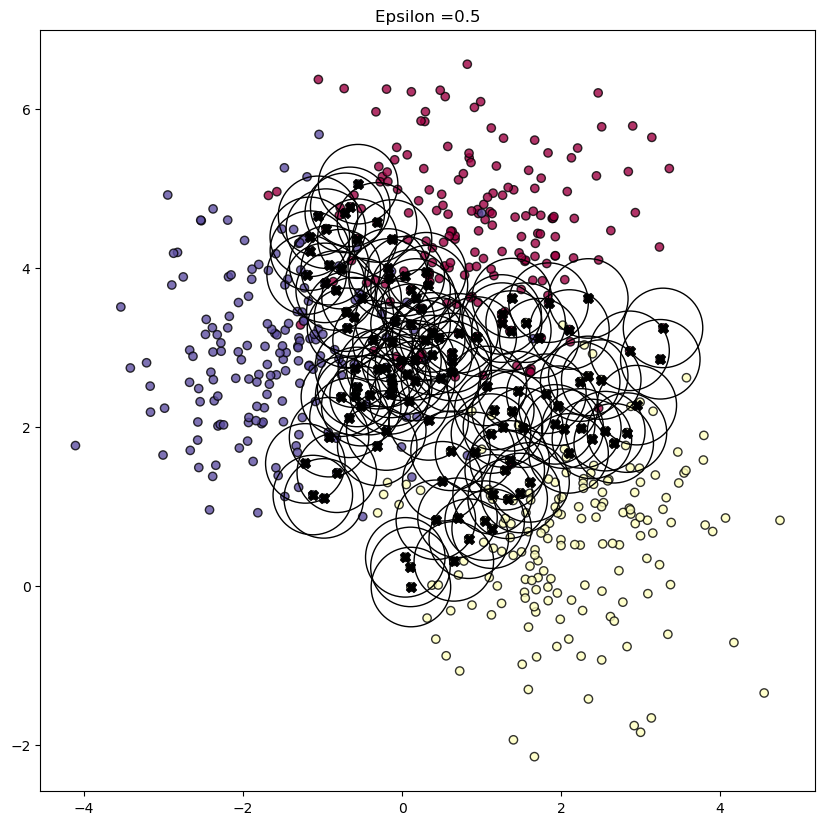

In [33]:
#figure, axes = plt.subplots()
fig = plt.figure(figsize=(10, 10))
axes = fig.add_subplot()
#axes.axis([-2.29,3.4,-1.82,2.25])
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(prototypes[:, 0], prototypes[:, 1], c='black', marker='X', s=50, edgecolors="k")
prototypes_l0, prototypes_l1 = [],[]
for i, j in zip(prototypes, prototype_labels):
    if j == 0:
        draw_circle = plt.Circle((i[0], i[1]), proto_selector._epsilon, fill=False, edgecolor='black', linewidth=1)
        axes.set_aspect(1)
        axes.add_artist(draw_circle)
    else:
        draw_circle1 = plt.Circle ((i[0], i[1]), proto_selector._epsilon, fill=False, edgecolor='black', linewidth=1)
        axes.set_aspect (1)
        axes.add_artist (draw_circle1)
#plt.tight_layout()
plt.title('Epsilon =' + str(proto_selector._epsilon))
plt.show()